In [1]:
from torch.utils.data import DataLoader,Dataset
import torch
import random
from pathlib import Path
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
#### Relevent only when using Google colab

#from google.colab import drive 
#drive.mount('/gdrive')

In [3]:
# Data Loader for AT & T Face Dataset

# A dictionary to map the original labels to the new labels
labels_map = {}
class FaceDataset(Dataset):  
    images = []
    labels = []
    def __init__(self,root_path):
        root_path = Path(root_path)
        c = 0
        for s in os.listdir(root_path):
            label_path = Path(root_path) / s
            labels_map[s] = c
            for i in os.listdir(label_path):
                path = label_path / i
                self.images.append(path)
                self.labels.append(c)  
            c += 1     
    def __getitem__(self,index):
        img = Image.open(self.images[index])
        t = transforms.Compose([transforms.ToTensor()])
        img = t(img)
        lbl = self.labels[index]
        img = img.flatten()
        return img, lbl 
    
    def __len__(self):
        return len(self.images)

In [4]:
input_size = 10304
num_classes = 40
class Classifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_size, 3000),
            nn.Sigmoid(),
            nn.Linear(3000, num_classes),
        )
        self.linear1 = torch.nn.Linear(input_size, num_classes)
        
    def forward(self,x):
        return self.block(x)

In [5]:
labels_map

{}

In [6]:
# Creating train and val loader

## Relevant for Google Drive
# dataset_path = "/gdrive/My Drive//faces"
dataset_path = "./faces"
dataset = FaceDataset(dataset_path)
train_set, val_set = torch.utils.data.random_split(dataset, [320, 80])
train_loader = DataLoader(train_set,batch_size=320,shuffle=True)
val_loader = DataLoader(val_set,batch_size=80,shuffle=True)
print(len(train_set))
print(len(val_set))

320
80


In [8]:
# Creating Target model instance
model = Classifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [9]:
epochs = 500
train_loss_values = []
val_loss_values = []
for i in range(epochs):
    # Training
    total_train_loss = 0
    total_val_loss = 0

    for imgs, labels in train_loader:
      optimizer.zero_grad()
      y_hat = model(imgs)
      train_loss = criterion(y_hat, labels)
      train_loss.backward()
      optimizer.step()
      total_train_loss += train_loss.item()
    # Validation
    for imgs, labels in val_loader:
      y_hat = model(imgs)
      val_loss = criterion(y_hat, labels)
      total_val_loss += val_loss.item()
    train_loss_values.append(total_train_loss/len(train_loader))
    val_loss_values.append(total_val_loss/len(val_loader))
    if i % 50 == 0:
      print('Epoch: {}, Train Loss: {}, Val Loss: {}'.format(i, total_train_loss/len(train_loader), total_val_loss/len(val_loader)))

Epoch: 0, Train Loss: 3.705707550048828, Val Loss: 7.594086647033691
Epoch: 50, Train Loss: 0.11304523050785065, Val Loss: 0.4139832556247711
Epoch: 100, Train Loss: 0.016440656036138535, Val Loss: 0.23090389370918274
Epoch: 150, Train Loss: 0.00809609703719616, Val Loss: 0.2029208242893219
Epoch: 200, Train Loss: 0.004963032901287079, Val Loss: 0.18906226754188538
Epoch: 250, Train Loss: 0.0033918407279998064, Val Loss: 0.18034645915031433
Epoch: 300, Train Loss: 0.002483807737007737, Val Loss: 0.17414502799510956
Epoch: 350, Train Loss: 0.0019093729788437486, Val Loss: 0.16967228055000305
Epoch: 400, Train Loss: 0.0015201176283881068, Val Loss: 0.166341170668602
Epoch: 450, Train Loss: 0.0012426612665876746, Val Loss: 0.16378088295459747


In [10]:
torch.save(model,"model.pth")
print(train_loss, val_loss)

tensor(0.0010, grad_fn=<NllLossBackward>) tensor(0.1618, grad_fn=<NllLossBackward>)


In [11]:
train_loss_values = torch.FloatTensor(train_loss_values)
val_loss_values = torch.FloatTensor(val_loss_values)

plt.plot(train_loss_values.detach().cpu().numpy())
plt.plot(val_loss_values.detach().cpu().numpy())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train_loss", "Val_loss"])
plt.savefig('./loss.png')

In [12]:
# Attack Algorithm
m = nn.Softmax(dim=0)
def MI_Face(x, label, alpha, lambda_):
    # Freeze target model weights
    for param in model.parameters():
      param.requires_grad = False
    # Start the attack
    c = labels_map[label]
    for i in range(alpha):
      x = torch.Tensor(x).view(1, -1)
      if not x.requires_grad:
          x.requires_grad = True
      pred = model(x)
      pr = m(pred.squeeze())
      loss = 1- pr[c]
      # if i % 100 == 0:
      #   print('Loss: {}'.format(loss.item()))
      loss.backward()  
      x = x - lambda_ * x.grad
      x = x.detach().numpy()
    return  x


In [14]:
# Attack Hyper parameters
alpha = 1000
lambda_ = 0.1


# Reconstruct the faces
results = []
for i in range (num_classes):
  label = 's' + str(i+1)
  print("Started the attack for identity {}".format(label))
  # Initializing an array that has the same size as input images
  x = np.zeros_like(imgs[0])
  img = MI_Face(x, label, alpha, lambda_)
  results.append(img)
print("Done!")

Started the attack for identity s1
Started the attack for identity s2
Started the attack for identity s3
Started the attack for identity s4
Started the attack for identity s5
Started the attack for identity s6
Started the attack for identity s7
Started the attack for identity s8
Started the attack for identity s9
Started the attack for identity s10
Started the attack for identity s11
Started the attack for identity s12
Started the attack for identity s13
Started the attack for identity s14
Started the attack for identity s15
Started the attack for identity s16
Started the attack for identity s17
Started the attack for identity s18
Started the attack for identity s19
Started the attack for identity s20
Started the attack for identity s21
Started the attack for identity s22
Started the attack for identity s23
Started the attack for identity s24
Started the attack for identity s25
Started the attack for identity s26
Started the attack for identity s27
Started the attack for identity s28
S

In [17]:
imgs[0].shape

torch.Size([10304])

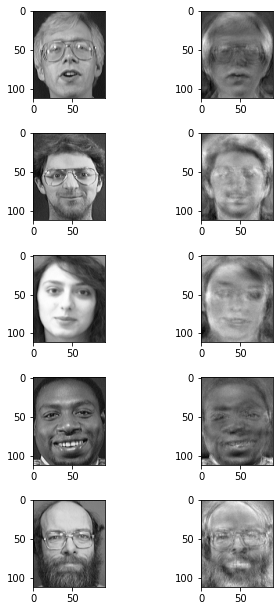

In [18]:
# Visualize a sample of the results
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 5
ids = ['s2', 's7', 's8', 's22', 's37']
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if (i-1)%2==0:
        anchor_img = np.asanyarray(Image.open(os.path.join(dataset_path, ids[int((i-1)/2)], str(random.randint(1, 10)) + '.pgm')))
        plt.imshow(anchor_img, cmap='gray')
    else:
        id = (int(ids[int((i/2)-1)][1:]))
        plt.imshow(results[id-1].reshape(112, 92), cmap='gray')
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [23]:
# Visualize all the results
try:
    os.mkdir("./model_inversion_output/")
except:
    pass

fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 8
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(results[i-1].reshape(112, 92), cmap='gray')
    plt.imsave("./model_inversion_output/" + str(i) + ".jpg",results[i-1].reshape(112, 92),cmap='gray')
plt.show()

In [21]:
# Evaluation using MSE and SSIM similarity metrics between the reconstructed face and a random image for the person
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import cv2 
for i in range (num_classes):
  anchor_img = np.asanyarray(Image.open(os.path.join(dataset_path, 's' + str(i+1), str(random.randint(1, 10)) + '.pgm')))
  reconsrtucted_img = results[i].reshape(112, 92)
  # Convert image to (0, 255) range
  reconsrtucted_img = cv2.normalize(reconsrtucted_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8)
  mse_distance = mean_squared_error(anchor_img, reconsrtucted_img)
  ssim_distance = ssim(anchor_img, reconsrtucted_img,
                    data_range=reconsrtucted_img.max() - reconsrtucted_img.min())
  print("Identity: {}, MSE: {:0.2f}, SSIM: {:0.2f}".format('s' + str(i+1),mse_distance, ssim_distance))


Identity: s1, MSE: 3199.91, SSIM: 0.20
Identity: s2, MSE: 2050.40, SSIM: 0.43
Identity: s3, MSE: 1802.64, SSIM: 0.39
Identity: s4, MSE: 2511.36, SSIM: 0.35
Identity: s5, MSE: 2142.80, SSIM: 0.24
Identity: s6, MSE: 2774.65, SSIM: 0.31
Identity: s7, MSE: 2920.02, SSIM: 0.44
Identity: s8, MSE: 2243.72, SSIM: 0.44
Identity: s9, MSE: 1919.09, SSIM: 0.42
Identity: s10, MSE: 4801.46, SSIM: 0.36
Identity: s11, MSE: 2515.50, SSIM: 0.32
Identity: s12, MSE: 1944.31, SSIM: 0.46
Identity: s13, MSE: 1839.99, SSIM: 0.32
Identity: s14, MSE: 2081.36, SSIM: 0.39
Identity: s15, MSE: 1728.36, SSIM: 0.28
Identity: s16, MSE: 2199.32, SSIM: 0.27
Identity: s17, MSE: 2349.27, SSIM: 0.32
Identity: s18, MSE: 1844.53, SSIM: 0.38
Identity: s19, MSE: 1661.14, SSIM: 0.45
Identity: s20, MSE: 3596.25, SSIM: 0.40
Identity: s21, MSE: 2208.08, SSIM: 0.26
Identity: s22, MSE: 1219.94, SSIM: 0.40
Identity: s23, MSE: 5005.59, SSIM: 0.36
Identity: s24, MSE: 1532.44, SSIM: 0.39
Identity: s25, MSE: 2585.05, SSIM: 0.40
Identity: